In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm.notebook import tqdm

In [67]:
df = pd.read_csv('data_with_descriptors.csv', low_memory=False)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 1840 entries, mol_id to mZagreb2
dtypes: bool(2), float64(860), int64(428), object(550)
memory usage: 280.5+ MB


# Drop incomplete features

In [69]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
boolean_columns = df.select_dtypes(include=['bool']).columns

df_num = df[numeric_columns]
df_cat = df[categorical_columns]
df_bool = df[boolean_columns]

In [70]:
print ('Количество колонок с числовыми признаками:', len(numeric_columns))
print ('Количество колонок с категориальными признаками:', len(categorical_columns))
print ('Количество колонок с булевыми значениями:', len(boolean_columns))

Количество колонок с числовыми признаками: 1288
Количество колонок с категориальными признаками: 550
Количество колонок с булевыми значениями: 2


In [71]:
df_cat

,mol_id,smiles,VR3_A,ATS0s,ATS1s,ATS2s,ATS3s,ATS4s,ATS5s,ATS6s,...,MDEN-12,MDEN-13,MDEN-22,MDEN-23,MDEN-33,RotRatio,TopoShapeIndex,PetitjeanIndex,VAdjMat,mZagreb1
0,gdb_45864,O=C1OC=NCC11CN1,3.433457680255007,95.34027777777777,58.208333333333336,100.62499999999999,121.24999999999997,106.75,10.0,3.0,...,float division by zero (MDEN-12),float division by zero (MDEN-13),0.33333333333333337,float division by zero (MDEN-23),float division by zero (MDEN-33),0.0,0.3333333333333333,0.25,4.321928094887362,2.673611111111111
1,gdb_11104,C1C(CN1C=O)C=O,3.0308503622828273,123.27777777777777,56.0,77.91666666666667,90.66666666666667,100.66666666666667,40.0,64.0,...,float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33),0.25,1.0,0.5,4.0,3.2222222222222223
2,gdb_47450,C1CC1N2CCOC2=O,3.347638510080779,87.80555555555556,53.583333333333336,106.30555555555556,89.99999999999999,99.33333333333334,64.0,8.0,...,float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33),0.1,1.0,0.5,4.321928094887362,2.5833333333333335
3,gdb_88940,OC1CC1NC(=N)C=O,3.5956495803580735,136.83333333333331,68.1111111111111,100.63888888888889,140.38888888888889,85.33333333333334,100.16666666666667,88.0,...,0.4999999999999999,float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33),0.2222222222222222,1.0,0.5,4.169925001442312,4.083333333333334
4,gdb_40813,C1NC1C1CCOC=N1,3.482606333903895,51.80555555555556,53.52777777777777,86.08333333333331,88.00000000000001,72.66666666666667,51.0,19.5,...,float division by zero (MDEN-12),float division by zero (MDEN-13),0.33333333333333337,float division by zero (MDEN-23),float division by zero (MDEN-33),0.1,0.6666666666666666,0.4,4.321928094887362,1.9722222222222223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,gdb_20951,CCOc1cnno1,3.0496274162907704,61.52777777777778,59.75,86.41666666666667,62.41666666666667,37.5,44.5,21.0,...,float division by zero (MDEN-12),float division by zero (MDEN-13),1.0,float division by zero (MDEN-23),float division by zero (MDEN-33),0.25,0.6666666666666666,0.4,4.0,2.611111111111111
19996,gdb_11254,CC1OC(C=C1)C#C,2.946857606451954,58.05555555555556,51.33333333333333,82.8611111111111,85.66666666666666,53.83333333333333,33.83333333333333,16.0,...,float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33),0.0,0.6666666666666666,0.4,4.0,3.2222222222222223
19997,gdb_34418,N#CC12COC1CCC2,3.3639060917480927,75.84027777777777,53.291666666666664,79.125,116.25,119.0,32.0,0.0,...,float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33),0.0,1.0,0.5,4.321928094887362,2.673611111111111
19998,gdb_46145,O=C1CCC(CO1)C#C,3.228615755024593,102.80555555555554,59.16666666666667,99.66666666666666,119.8888888888889,107.16666666666666,52.16666666666667,31.666666666666664,...,float division by zero (MDEN-12),float division by zero (MDEN-13),float division by zero (MDEN-22),float division by zero (MDEN-23),float division by zero (MDEN-33),0.0,1.0,0.5,4.169925001442312,3.4722222222222223


In [72]:
# Replace errors in unloading descriptors with NaN values
for col in tqdm(categorical_columns):
    df[col] = df[col].replace(to_replace=[r'^invalid value.*', r'^float division.*', r'^max().*', r'^min().*', r'^module.*' ],
                              value=np.nan, regex=True).infer_objects()

  0%|          | 0/550 [00:00<?, ?it/s]

In [73]:
numeric_like_columns = []
for col in tqdm(df.columns):
    try:
        # Пробуем преобразовать значения в колонке в числа
        pd.to_numeric(df[col])
        # Если успешно, добавляем колонку в список numeric_like_columns
        numeric_like_columns.append(col)
    except ValueError:
        # Если преобразование вызывает ошибку, это означает, что колонка не содержит только числа
        pass

# Изменение типа данных колонок на float
df[numeric_like_columns] = df[numeric_like_columns].astype(float)

  0%|          | 0/1840 [00:00<?, ?it/s]

In [74]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
boolean_columns = df.select_dtypes(include=['bool']).columns
print ('Количество колонок с числовыми признаками:', len(numeric_columns))
print ('Количество колонок с категориальными признаками:', len(categorical_columns))
print ('Количество колонок с булевыми значениями:', len(boolean_columns))

Количество колонок с числовыми признаками: 1763
Количество колонок с категориальными признаками: 77
Количество колонок с булевыми значениями: 0


In [75]:
# Deleting columns with number of NaN values > 1000
THRESHOLD = 1000
df.dropna(thresh=len(df) - THRESHOLD, axis=1, inplace=True)

In [76]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
boolean_columns = df.select_dtypes(include=['bool']).columns
print ('Количество колонок с числовыми признаками:', len(numeric_columns))
print ('Количество колонок с категориальными признаками:', len(categorical_columns))
print ('Количество колонок с булевыми значениями:', len(boolean_columns))

Количество колонок с числовыми признаками: 1439
Количество колонок с категориальными признаками: 65
Количество колонок с булевыми значениями: 0


In [77]:
categorical_columns

Index(['mol_id', 'smiles', 'VR3_A', 'ATS0s', 'ATS1s', 'ATS2s', 'ATS3s',
       'ATS4s', 'ATS5s', 'ATS6s', 'ATS7s', 'ATS8s', 'AATS0s', 'AATS1s',
       'AATS2s', 'AATS3s', 'AATS4s', 'AATS5s', 'ATSC0s', 'ATSC1s', 'ATSC2s',
       'ATSC3s', 'ATSC4s', 'ATSC5s', 'ATSC6s', 'ATSC7s', 'ATSC8s', 'AATSC0s',
       'AATSC1s', 'AATSC2s', 'AATSC3s', 'AATSC4s', 'AATSC5s', 'MATS1s',
       'MATS2s', 'MATS3s', 'MATS4s', 'MATS5s', 'GATS1s', 'GATS2s', 'GATS3s',
       'GATS4s', 'GATS5s', 'BCUTs-1h', 'BCUTs-1l', 'VR3_DzZ', 'VR3_Dzm',
       'VR3_Dzv', 'VR3_Dzse', 'VR3_Dzpe', 'VR3_Dzare', 'VR3_Dzp', 'VR3_Dzi',
       'HybRatio', 'Xp-0d', 'AXp-0d', 'Xp-0dv', 'AXp-0dv', 'VR3_D',
       'ETA_eta_B', 'AETA_eta_B', 'ETA_eta_BR', 'AETA_eta_BR', 'VAdjMat',
       'mZagreb1'],
      dtype='object')

In [78]:
df.HybRatio.value_counts()

1.0                                            6959
0.8333333333333334                             2098
0.8                                            1312
0.8571428571428571                             1183
0.5                                            1096
0.75                                           1080
0.0                                             930
0.6                                             879
0.6666666666666666                              856
0.3333333333333333                              505
0.7142857142857143                              493
0.25                                            455
0.2                                             454
0.4                                             431
0.5714285714285714                              417
0.16666666666666666                             163
0.42857142857142855                             162
0.875                                           158
0.7777777777777778                              125
0.2857142857

In [79]:
# Replace 'there are no sp3 and sp2 carbons' in unloading descriptors with NaN values
for col in categorical_columns:
    df[col] = df[col].replace(to_replace=[r'^there.*'],
                              value=np.nan, regex=True).infer_objects()

In [80]:
cols_to_numeric = ['VR3_A', 'ATS0s', 'ATS1s', 'ATS2s', 'ATS3s',
       'ATS4s', 'ATS5s', 'ATS6s', 'ATS7s', 'ATS8s', 'AATS0s', 'AATS1s',
       'AATS2s', 'AATS3s', 'AATS4s', 'AATS5s', 'ATSC0s', 'ATSC1s', 'ATSC2s',
       'ATSC3s', 'ATSC4s', 'ATSC5s', 'ATSC6s', 'ATSC7s', 'ATSC8s', 'AATSC0s',
       'AATSC1s', 'AATSC2s', 'AATSC3s', 'AATSC4s', 'AATSC5s', 'MATS1s',
       'MATS2s', 'MATS3s', 'MATS4s', 'MATS5s', 'GATS1s', 'GATS2s', 'GATS3s',
       'GATS4s', 'GATS5s', 'BCUTs-1h', 'BCUTs-1l', 'VR3_DzZ', 'VR3_Dzm',
       'VR3_Dzv', 'VR3_Dzse', 'VR3_Dzpe', 'VR3_Dzare', 'VR3_Dzp', 'VR3_Dzi',
       'HybRatio', 'Xp-0d', 'AXp-0d', 'Xp-0dv', 'AXp-0dv', 'VR3_D',
       'ETA_eta_B', 'AETA_eta_B', 'ETA_eta_BR', 'AETA_eta_BR', 'VAdjMat',
       'mZagreb1']

def to_numeric_or_none(value):
    try:
        return pd.to_numeric(value)
    except ValueError:
        return None
    
df[cols_to_numeric] = df[cols_to_numeric].applymap(to_numeric_or_none)

In [81]:
df

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,gdb_45864,O=C1OC=NCC11CN1,2.65458,1.85295,1.23017,1.4059,66.11,-0.2693,-0.0363,0.2331,...,9.475854,59.263520,126.042927,8.402862,79.0,11.0,50.0,61.0,2.673611,1.958333
1,gdb_11104,C1C(CN1C=O)C=O,4.94875,1.15582,1.13915,3.8620,64.32,-0.2496,-0.0414,0.2082,...,8.979291,37.044791,113.047678,7.536512,70.0,6.0,36.0,40.0,3.222222,2.000000
2,gdb_47450,C1CC1N2CCOC2=O,3.08235,1.38222,1.01814,4.6197,72.18,-0.2461,0.0510,0.2972,...,9.064274,58.079349,127.063329,7.059074,83.0,9.0,48.0,57.0,2.583333,1.972222
3,gdb_88940,OC1CC1NC(=N)C=O,3.95367,0.82949,0.72068,4.6363,74.62,-0.2233,-0.0636,0.1597,...,8.834774,57.095844,128.058577,7.532857,98.0,7.0,42.0,47.0,4.083333,2.111111
4,gdb_40813,C1NC1C1CCOC=N1,4.14610,1.04198,0.87868,2.6945,76.88,-0.2405,0.0257,0.2662,...,8.954286,56.778649,126.079313,6.635753,87.0,9.0,46.0,53.0,1.972222,2.027778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,gdb_20951,CCOc1cnno1,7.81782,1.16858,1.02975,4.2179,61.95,-0.2426,-0.0227,0.2199,...,8.124743,47.992435,114.042927,8.145923,67.0,5.0,34.0,36.0,2.611111,2.000000
19996,gdb_11254,CC1OC(C=C1)C#C,5.06532,1.39767,1.22187,1.6287,72.66,-0.2464,0.0068,0.2532,...,8.365672,49.065586,108.057515,6.753595,63.0,6.0,36.0,39.0,3.222222,1.916667
19997,gdb_34418,N#CC12COC1CCC2,2.32431,1.67523,1.25940,3.1914,75.22,-0.2686,0.0191,0.2876,...,9.713597,54.600998,123.068414,6.837134,78.0,10.0,50.0,62.0,2.673611,2.041667
19998,gdb_46145,O=C1CCC(CO1)C#C,4.58871,0.99416,0.84701,3.9391,74.90,-0.2643,0.0061,0.2704,...,8.590258,37.289972,124.052429,7.297202,90.0,9.0,40.0,43.0,3.472222,2.166667


In [82]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
boolean_columns = df.select_dtypes(include=['bool']).columns
print ('Количество колонок с числовыми признаками:', len(numeric_columns))
print ('Количество колонок с категориальными признаками:', len(categorical_columns))
print ('Количество колонок с булевыми значениями:', len(boolean_columns))

Количество колонок с числовыми признаками: 1502
Количество колонок с категориальными признаками: 2
Количество колонок с булевыми значениями: 0


In [83]:
df.to_csv('clean1.csv', index=False)

In [84]:
df.columns

Index(['mol_id', 'smiles', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap',
       ...
       'SRW10', 'TSRW10', 'MW', 'AMW', 'WPath', 'WPol', 'Zagreb1', 'Zagreb2',
       'mZagreb1', 'mZagreb2'],
      dtype='object', length=1504)

# Dealing with NaN

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 1504 entries, mol_id to mZagreb2
dtypes: float64(1502), object(2)
memory usage: 229.5+ MB


In [92]:
df_without_NaN = df.dropna()
len(df_without_NaN)

19652

In [90]:
mean_value = df['HybRatio'].mean()
df['HybRatio'].fillna(mean_value, inplace=True)

In [91]:
null_counts = df_without_NaN.isnull().sum()
nulls = null_counts[null_counts > 0]
nulls

Series([], dtype: int64)

In [93]:
df_without_NaN = df.dropna()
len(df_without_NaN)

19652

In [94]:
df_without_NaN.to_csv('clean2.csv', index=False)

# Drop features with high correlation

Удаляем таргетную величину, а также параметры 'homo' и 'lumo' напрямую коррелирующие с таргетным значением

In [95]:
df_num = df_without_NaN[numeric_columns].drop(['gap', 'homo', 'lumo'], axis = 1)

In [96]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19652 entries, 0 to 19999
Columns: 1499 entries, A to mZagreb2
dtypes: float64(1499)
memory usage: 224.9 MB


In [98]:
corr_matrix = df_num.corr().abs()

# Создание маски для верхнего треугольника матрицы корреляций
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Нахождение индексов столбцов с корреляцией больше 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Удаление сильновзаимосвязанных признаков
df_after_corr = df_num.drop(columns=to_drop)

print("Количество признаков после удаления коррелирующих:", df_after_corr.shape[1])

Количество признаков после удаления коррелирующих: 520


In [99]:
len(to_drop)

979

In [100]:
df_after_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19652 entries, 0 to 19999
Columns: 520 entries, A to TopoShapeIndex
dtypes: float64(520)
memory usage: 78.1 MB


In [101]:
df_after_corr.to_csv('after_corr.csv', index=False)

# Drop features with (near-)zero variance

In [102]:
from sklearn.feature_selection import VarianceThreshold

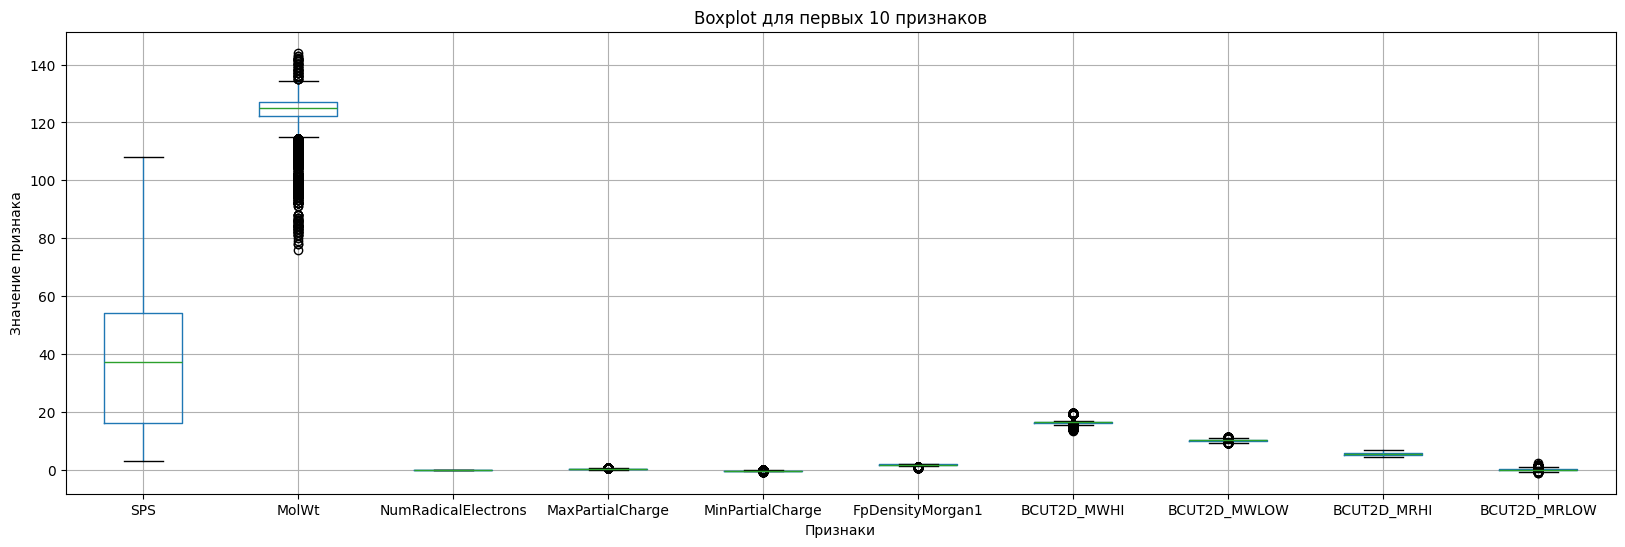

In [109]:
features_to_plot = df_after_corr.iloc[:, 11:21]

# Создадим boxplot для выбранных признаков
plt.figure(figsize=(20, 6))
features_to_plot.boxplot()
plt.title('Boxplot для первых 10 признаков')
plt.ylabel('Значение признака')
plt.xlabel('Признаки')
plt.show()

In [124]:
threshold = 0.15

# Создание объекта VarianceThreshold
selector = VarianceThreshold(threshold)

df_clean = df_after_corr.copy()
selector.fit(df_clean)

mask = selector.get_support()

# Фильтрация: только признаки, прошедшие порог
df_clean = df_clean.loc[:, mask]

In [125]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19652 entries, 0 to 19999
Columns: 177 entries, A to Radius
dtypes: float64(177)
memory usage: 26.7 MB


In [126]:
df_clean.to_csv('after_corr.csv', index = False)

# Save clean data

In [127]:
data_clean = df_without_NaN[['smiles', 'gap']].merge(df_clean, how='inner', left_index=True, right_index=True)

In [128]:
data_clean

,smiles,gap,A,B,mu,alpha,u0,cv,MaxAbsEStateIndex,MinEStateIndex,...,n5Ring,n6Ring,n3HRing,n4HRing,n5HRing,n5AHRing,nFRing,GGI2,GGI3,Radius
0,O=C1OC=NCC11CN1,0.2331,2.65458,1.85295,1.4059,66.11,-453.960419,27.142,10.802361,-0.421875,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.444444,0.729167,3.0
1,C1C(CN1C=O)C=O,0.2082,4.94875,1.15582,3.8620,64.32,-399.811727,26.627,9.906019,0.111296,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.444444,0.750000,3.0
2,C1CC1N2CCOC2=O,0.2972,3.08235,1.38222,4.6197,72.18,-439.118302,29.710,10.759444,-0.113426,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.944444,0.500000,2.0
3,OC1CC1NC(=N)C=O,0.1597,3.95367,0.82949,4.6363,74.62,-455.127740,33.649,9.806103,-0.356204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.444444,0.375000,3.0
4,C1NC1C1CCOC=N1,0.2662,4.14610,1.04198,2.6945,76.88,-419.189278,30.168,4.958194,0.498843,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.500000,0.381944,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,CCOc1cnno1,0.2199,7.81782,1.16858,4.2179,61.95,-415.833772,26.660,4.854167,0.368056,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.444444,0.222222,3.0
19996,CC1OC(C=C1)C#C,0.2532,5.06532,1.39767,1.6287,72.66,-346.571037,29.171,5.163194,-0.078704,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.666667,0.569444,3.0
19997,N#CC12COC1CCC2,0.2876,2.32431,1.67523,3.1914,75.22,-401.959779,29.412,8.716944,-0.041667,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.444444,0.812500,2.0
19998,O=C1CCC(CO1)C#C,0.2704,4.58871,0.99416,3.9391,74.90,-421.836918,31.180,10.433724,-0.123611,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.888889,0.250000,3.0


In [129]:
data_clean.to_csv('data_clean.csv', index=False)

# Genetic algorithm for feature selection

In [20]:
data_clean = pd.read_csv('data_clean.csv')
df_clean = pd.read_csv('after_corr.csv')

In [21]:
from sklearn.datasets import make_classification
from genetic_selection import GeneticSelectionCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [23]:
X = df_clean
y = data_clean['gap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the GeneticSelectionCV
selector = GeneticSelectionCV(RandomForestRegressor(), cv=5, verbose=2, scoring="neg_mean_squared_error", n_population=50, crossover_proba=0.5,
                               mutation_proba=0.2, n_generations=40, crossover_independent_proba=0.5,
                               mutation_independent_proba=0.05, tournament_size=3, caching=True, n_jobs=-1)

# Fit the selector on the training data
selector.fit(X_train, y_train)

# Get the selected feature indices
selected_features = X.columns[selector.support_]

Selecting features with genetic algorithm.


In [ ]:
selected_features